In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

KeyboardInterrupt: 

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  
os.environ["DLIB_USE_CUDA"] = "0"


!pip install --no-cache-dir tqdm pandas opencv-python

print("✅ Installation complete!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 166.5 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.6 which is incompatible.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.15.3 which is incompatible.
mkl-umath 0.1.1 requires numpy<1.27.0,>=1.26.4, but you have numpy 2.2.6 which is incompatible.
mkl-random 1.2.4 requires numpy<1.27.0,>=1.26.4, but you have numpy 2.2.6 which is incompatible.
mkl-fft 1.3.8 requires numpy<1.27

In [4]:
import json
import glob
import numpy as np
import cv2
import pandas as pd
from tqdm.autonotebook import tqdm
import shutil

print("✅ Libraries imported")


✅ Libraries imported


/tmp/ipykernel_37/1753983756.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [5]:
print("="*60)
print("🔍 Setting up paths")
print("="*60)

sd_modern_base = '/kaggle/input/stable-diffusion-dataaaaaaaaa'

ffhq_possible_paths = [
    '/kaggle/input/flickrfaceshq-dataset-ffhq',
    '/kaggle/input/flickr-faces-hq-dataset-ffhq',
    '/kaggle/input/ffhq',
]

ffhq_base = None
for path in ffhq_possible_paths:
    if os.path.exists(path):
        ffhq_base = path
        break

if ffhq_base is None:
    print("⚠️  FFHQ not found! Checking what datasets are available...")
    print("\nAvailable datasets:")
    !ls -la /kaggle/input/
    ffhq_base = '/kaggle/input/flickrfaceshq-dataset-ffhq' 

print(f"FFHQ path: {ffhq_base}")

output_base = '/kaggle/working/processed_faces'
real_out_dir = os.path.join(output_base, 'real')
fake_out_dir = os.path.join(output_base, 'fake')

os.makedirs(real_out_dir, exist_ok=True)
os.makedirs(fake_out_dir, exist_ok=True)

print(f"✅ Output directories created:")
print(f"   Real: {real_out_dir}")
print(f"   Fake: {fake_out_dir}")


🔍 Setting up paths
FFHQ path: /kaggle/input/flickrfaceshq-dataset-ffhq
✅ Output directories created:
   Real: /kaggle/working/processed_faces/real
   Fake: /kaggle/working/processed_faces/fake


In [6]:
print("\n" + "="*60)
print("📂 Loading images from BOTH datasets")
print("="*60)

extensions = ['*.jpg', '*.jpeg', '*.JPG', '*.JPEG', '*.png', '*.PNG']

sd_fake = []  
ffhq_real = []  

print("\n🔍 Loading Stable Diffusion images (AI-generated/fake)...")

if os.path.exists(sd_modern_base):
    base_dataset = os.path.join(sd_modern_base, 'stable-diffusion-face-dataset')
    
    if os.path.exists(base_dataset):
        print(f"  Found dataset folder: {base_dataset}")
        
        for resolution in ['512', '768', '1024']:
            res_path = os.path.join(base_dataset, resolution)
            if os.path.exists(res_path):
                print(f"\n  📁 Resolution: {resolution}px")
                
                for gender in ['man', 'woman']:
                    gender_path = os.path.join(res_path, gender)
                    if os.path.exists(gender_path):
                        
                        for ext in extensions:
                            imgs = glob.glob(os.path.join(gender_path, ext))
                            sd_fake += imgs
                        
                        jpg_count = len(glob.glob(os.path.join(gender_path, '*.jpg')))
                        print(f"    {gender}: {jpg_count} images")
    else:
        
        print("  Using fallback recursive search...")
        for root, dirs, files in os.walk(sd_modern_base):
            if '.git' in root or '.idea' in root:
                continue
            
            for ext in extensions:
                imgs = glob.glob(os.path.join(root, ext))
                sd_fake += imgs
    
    sd_fake = list(set(sd_fake))
    print(f"\n✅ Stable Diffusion loaded: {len(sd_fake)} AI-generated images")
else:
    print("❌ Stable Diffusion dataset not found!")

print("\n🔍 Loading FFHQ images (real faces)...")

if os.path.exists(ffhq_base):
    ffhq_paths = [
        ffhq_base,
        os.path.join(ffhq_base, 'thumbnails128x128'),
        os.path.join(ffhq_base, 'images1024x1024'),
        os.path.join(ffhq_base, 'images'),
        os.path.join(ffhq_base, 'ffhq'),
    ]
    
    for check_path in ffhq_paths:
        if os.path.exists(check_path):
            print(f"  Checking: {check_path}")
            
            for ext in extensions:
                imgs = glob.glob(os.path.join(check_path, ext))
                ffhq_real += imgs
                
                imgs = glob.glob(os.path.join(check_path, '*', ext))
                ffhq_real += imgs
    
    if len(ffhq_real) == 0:
        print("  Using recursive search...")
        for root, dirs, files in os.walk(ffhq_base):
            for ext in extensions:
                imgs = glob.glob(os.path.join(root, ext))
                ffhq_real += imgs
    
    ffhq_real = list(set(ffhq_real))
    print(f"\n✅ FFHQ loaded: {len(ffhq_real)} real images")
    
    if len(ffhq_real) > len(sd_fake):
        import random
        random.seed(42)
        ffhq_real = random.sample(ffhq_real, len(sd_fake))
        print(f"   ⚖️  Balanced to {len(ffhq_real)} images (matching fake count)")
else:
    print("❌ FFHQ dataset not found!")
    print("   Add it: Search 'flickr-faces-hq-dataset-ffhq' on Kaggle")

print("\n" + "="*60)
print("📊 COMBINED DATASET SUMMARY")
print("="*60)

all_real_images = ffhq_real
all_fake_images = sd_fake

print(f"Real images (FFHQ): {len(all_real_images)}")
print(f"Fake images (Stable Diffusion): {len(all_fake_images)}")
print(f"\n🎯 TOTAL IMAGES: {len(all_real_images) + len(all_fake_images)}")

if len(all_real_images) > 0:
    print(f"\n✅ Sample real image: {all_real_images[0]}")
if len(all_fake_images) > 0:
    print(f"✅ Sample fake image: {all_fake_images[0]}")

if len(all_real_images) == 0 or len(all_fake_images) == 0:
    print("\n❌ ERROR: Missing real OR fake images!")
    print("Make sure both datasets are added to your Kaggle notebook.")

print("="*60)


📂 Loading images from BOTH datasets

🔍 Loading Stable Diffusion images (AI-generated/fake)...
  Found dataset folder: /kaggle/input/stable-diffusion-dataaaaaaaaa/stable-diffusion-face-dataset

  📁 Resolution: 512px
    man: 1500 images
    woman: 1500 images

  📁 Resolution: 768px
    man: 1500 images
    woman: 1500 images

  📁 Resolution: 1024px
    man: 1500 images
    woman: 1500 images

✅ Stable Diffusion loaded: 9000 AI-generated images

🔍 Loading FFHQ images (real faces)...
  Checking: /kaggle/input/flickrfaceshq-dataset-ffhq

✅ FFHQ loaded: 52001 real images
   ⚖️  Balanced to 9000 images (matching fake count)

📊 COMBINED DATASET SUMMARY
Real images (FFHQ): 9000
Fake images (Stable Diffusion): 9000

🎯 TOTAL IMAGES: 18000

✅ Sample real image: /kaggle/input/flickrfaceshq-dataset-ffhq/01911.png
✅ Sample fake image: /kaggle/input/stable-diffusion-dataaaaaaaaa/stable-diffusion-face-dataset/512/man/man_1160.jpg


In [7]:
if len(all_real_images) > 0 and len(all_fake_images) > 0:
    print("\n" + "="*60)
    print("✅ DATASETS READY!")
    print("="*60)
    print(f"Real faces: {len(all_real_images)}")
    print(f"Fake faces: {len(all_fake_images)}")
    
    ratio = len(all_real_images) / len(all_fake_images) if len(all_fake_images) > 0 else 0
    if 0.8 <= ratio <= 1.2:
        print("✅ Dataset is well-balanced!")
    else:
        print(f"⚠️  Imbalanced: ratio is {ratio:.2f}")
    print("="*60)
else:
    print("\n" + "="*60)
    print("❌ ERROR: Missing dataset!")
    print("="*60)
    if len(all_real_images) == 0:
        print("Missing: REAL faces")
        print("Add FFHQ: Search 'flickr-faces-hq-dataset-ffhq'")
    if len(all_fake_images) == 0:
        print("Missing: FAKE faces")
        print("Add Stable Diffusion: Search 'stable-diffusion-dataaaaaaaaa'")
    print("="*60)



✅ DATASETS READY!
Real faces: 9000
Fake faces: 9000
✅ Dataset is well-balanced!


In [8]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
print("\n✅ Face detection model loaded successfully!")



✅ Face detection model loaded successfully!


In [9]:
def process_images(image_list, label, out_dir, max_images=None):
    """
    Process images - SIMPLIFIED VERSION (No face detection, just resize)
    These datasets already contain cropped faces, so we just resize them!

    Args:
        image_list: List of image paths
        label: 'REAL' or 'FAKE'
        out_dir: Output directory for processed faces
        max_images: Maximum number of images to process (None = all)
    """
    from PIL import Image
    
    processed_count = 0
    error_count = 0

    images_to_process = image_list[:max_images] if max_images else image_list

    for img_path in tqdm(images_to_process, desc=f"Processing {label} images"):
        try:
            pil_img = Image.open(img_path)
            
            if pil_img.mode != 'RGB':
                pil_img = pil_img.convert('RGB')
            
            resized_img = pil_img.resize((112, 112), Image.LANCZOS)

            orig_name = os.path.basename(img_path)
            name_without_ext = os.path.splitext(orig_name)[0]
            output_filename = f"{name_without_ext}.jpg"
            output_path = os.path.join(out_dir, output_filename)

            counter = 1
            while os.path.exists(output_path):
                output_filename = f"{name_without_ext}_{counter}.jpg"
                output_path = os.path.join(out_dir, output_filename)
                counter += 1

            resized_img.save(output_path, 'JPEG', quality=95)
            
            if os.path.exists(output_path) and os.path.getsize(output_path) > 0:
                processed_count += 1
            else:
                error_count += 1

        except Exception as e:
            error_count += 1
            if error_count <= 10:
                print(f"\nError: {e}")

    return processed_count, 0, error_count

print("✅ Processing function defined (SIMPLIFIED - no face detection)!")

✅ Processing function defined (SIMPLIFIED - no face detection)!


In [10]:
total_images = len(all_real_images) + len(all_fake_images)

if total_images == 0:
    print("\n❌ ERROR: No images found!")
    print("Make sure the Stable Diffusion dataset is added to your notebook.")
elif len(all_real_images) == 0 or len(all_fake_images) == 0:
    print("\n⚠️  WARNING: Only one class of images found!")
    print("You need BOTH real and fake images to train a classifier.")
    print("Please add a real faces dataset (like FFHQ).")
else:
    print("\n" + "="*60)
    print("🚀 Starting Face Extraction")
    print(f"   Total images to process: {total_images}")
    print("="*60)

    if len(all_real_images) > 0:
        print("\n📸 Processing REAL images...")
        real_processed, real_no_face, real_errors = process_images(
            all_real_images,
            'REAL',
            real_out_dir
        )

        print(f"\n✅ Real images processed: {real_processed}")
        print(f"⚠️  No face detected: {real_no_face}")
        print(f"❌ Errors: {real_errors}")

    if len(all_fake_images) > 0:
        print("\n📸 Processing FAKE (AI-Generated) images...")
        fake_processed, fake_no_face, fake_errors = process_images(
            all_fake_images,
            'FAKE',
            fake_out_dir
        )

        print(f"\n✅ Fake images processed: {fake_processed}")
        print(f"⚠️  No face detected: {fake_no_face}")
        print(f"❌ Errors: {fake_errors}")

    real_faces = []
    fake_faces = []
    
    for ext in ['*.jpg', '*.jpeg', '*.JPG', '*.JPEG', '*.png', '*.PNG']:
        real_faces += glob.glob(os.path.join(real_out_dir, ext))
        fake_faces += glob.glob(os.path.join(fake_out_dir, ext))

    print("\n" + "="*60)
    print("🎉 PROCESSING COMPLETE!")
    print("="*60)
    print(f"Real faces extracted: {len(real_faces)}")
    print(f"Fake faces extracted: {len(fake_faces)}")
    print(f"Total faces extracted: {len(real_faces) + len(fake_faces)}")
    
    print("\n🔍 Debug - Checking output folders:")
    print(f"  Real folder: {real_out_dir}")
    !ls {real_out_dir} | head -10
    print(f"  Fake folder: {fake_out_dir}")
    !ls {fake_out_dir} | head -10
    
    print("\n🎯 Dataset Focus: Modern AI (Stable Diffusion 2024)")
    print("="*60)


🚀 Starting Face Extraction
   Total images to process: 18000

📸 Processing REAL images...


Processing REAL images:   0%|          | 0/9000 [00:00<?, ?it/s]


✅ Real images processed: 9000
⚠️  No face detected: 0
❌ Errors: 0

📸 Processing FAKE (AI-Generated) images...


Processing FAKE images:   0%|          | 0/9000 [00:00<?, ?it/s]


✅ Fake images processed: 9000
⚠️  No face detected: 0
❌ Errors: 0

🎉 PROCESSING COMPLETE!
Real faces extracted: 9000
Fake faces extracted: 9000
Total faces extracted: 18000

🔍 Debug - Checking output folders:
  Real folder: /kaggle/working/processed_faces/real
00001.jpg
00004.jpg
00005.jpg
00009.jpg
00011.jpg
00018.jpg
00030.jpg
00032.jpg
00037.jpg
00062.jpg
ls: write error: Broken pipe
  Fake folder: /kaggle/working/processed_faces/fake
man_0001_1.jpg
man_0001.jpg
man_0002_1.jpg
man_0002.jpg
man_0003_1.jpg
man_0003.jpg
man_0004_1.jpg
man_0004.jpg
man_0005_1.jpg
man_0005.jpg
ls: write error: Broken pipe

🎯 Dataset Focus: Modern AI (Stable Diffusion 2024)


In [11]:
import pandas as pd
import os
import glob

print("="*60)
print("📊 Creating Metadata CSV")
print("="*60)

real_out_dir = '/kaggle/working/processed_faces/real'
fake_out_dir = '/kaggle/working/processed_faces/fake'

real_faces = glob.glob(os.path.join(real_out_dir, '*.jpg'))
fake_faces = glob.glob(os.path.join(fake_out_dir, '*.jpg'))

print(f"\n🔍 Found:")
print(f"  Real images: {len(real_faces)}")
print(f"  Fake images: {len(fake_faces)}")

filenames = []
labels = []
paths = []

for img_path in real_faces:
    filename = os.path.basename(img_path)
    filenames.append(filename)
    labels.append('real')
    paths.append(f'real/{filename}')

for img_path in fake_faces:
    filename = os.path.basename(img_path)
    filenames.append(filename)
    labels.append('fake')
    paths.append(f'fake/{filename}')

final_df = pd.DataFrame({
    'filename': filenames,
    'label': labels,
    'path': paths
})

final_df.to_csv('/kaggle/working/metadata.csv', index=False)

print(f"\n✅ Metadata created with {len(final_df)} entries")
print("\n📊 Label distribution:")
print(final_df['label'].value_counts())

print("\n" + "="*60)
print("✅ PREPROCESSING COMPLETE!")
print("="*60)
print("📂 Files saved:")
print(f"  Real faces: {real_out_dir}/")
print(f"  Fake faces: {fake_out_dir}/")
print(f"  Metadata: /kaggle/working/metadata.csv")
print("\n🚀 Ready for training!")
print("="*60)

print("\n📋 Sample metadata:")
print(final_df.head(10))

📊 Creating Metadata CSV

🔍 Found:
  Real images: 9000
  Fake images: 9000

✅ Metadata created with 18000 entries

📊 Label distribution:
label
real    9000
fake    9000
Name: count, dtype: int64

✅ PREPROCESSING COMPLETE!
📂 Files saved:
  Real faces: /kaggle/working/processed_faces/real/
  Fake faces: /kaggle/working/processed_faces/fake/
  Metadata: /kaggle/working/metadata.csv

🚀 Ready for training!

📋 Sample metadata:
    filename label            path
0  00538.jpg  real  real/00538.jpg
1  38991.jpg  real  real/38991.jpg
2  49217.jpg  real  real/49217.jpg
3  51494.jpg  real  real/51494.jpg
4  52959.jpg  real  real/52959.jpg
5  50521.jpg  real  real/50521.jpg
6  38755.jpg  real  real/38755.jpg
7  48649.jpg  real  real/48649.jpg
8  41372.jpg  real  real/41372.jpg
9  22941.jpg  real  real/22941.jpg


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sn
import sys
from tqdm import tqdm

print("="*60)
print("🚀 DEEPFAKE DETECTOR TRAINING")
print("   Modern AI Dataset (Stable Diffusion 2024)")
print("="*60)

🚀 DEEPFAKE DETECTOR TRAINING
   Modern AI Dataset (Stable Diffusion 2024)


In [13]:
USE_SUBSET = False  
SUBSET_PERCENTAGE = 0.10
RESUME_TRAINING = False  
num_epochs = 15  
lr = 1e-4
batch_size = 32

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n🖥️  Device: {device}")
print(f"📊 Epochs: {num_epochs}")
print(f"🔬 Subset Mode: {'ON (10% data)' if USE_SUBSET else 'OFF (Full dataset)'}")
print(f"💾 Batch Size: {batch_size}")



🖥️  Device: cpu
📊 Epochs: 15
🔬 Subset Mode: OFF (Full dataset)
💾 Batch Size: 32


In [14]:
print("\n" + "="*60)
print("📂 Loading Dataset")
print("="*60)

metadata = pd.read_csv('/kaggle/working/metadata.csv')
print(f"✅ Metadata loaded: {len(metadata)} images")
print(f"   Real: {len(metadata[metadata['label']=='real'])}")
print(f"   Fake: {len(metadata[metadata['label']=='fake'])}")

base_path = '/kaggle/working/processed_faces'
metadata['full_path'] = metadata['path'].apply(lambda x: os.path.join(base_path, x))

metadata['numeric_label'] = metadata['label'].apply(lambda x: 1 if x == 'real' else 0)

if USE_SUBSET:
    print(f"\n🔬 QUICK TEST MODE: Using {SUBSET_PERCENTAGE*100}% of dataset")
    metadata = metadata.sample(frac=SUBSET_PERCENTAGE, random_state=42)
    print(f"   Subset size: {len(metadata)} images")

train_df, val_df = train_test_split(
    metadata,
    test_size=0.2,
    stratify=metadata['numeric_label'],
    random_state=42
)

print(f"\n📊 Dataset Split:")
print(f"   Training: {len(train_df)} images")
print(f"   Validation: {len(val_df)} images")
print(f"   Train - Real: {sum(train_df['numeric_label'])}, Fake: {len(train_df) - sum(train_df['numeric_label'])}")
print(f"   Val - Real: {sum(val_df['numeric_label'])}, Fake: {len(val_df) - sum(val_df['numeric_label'])}")

batches_per_epoch = len(train_df) // batch_size
minutes_per_epoch = batches_per_epoch * 0.5 / 60  
total_minutes = minutes_per_epoch * num_epochs

print(f"\n⏱️  Estimated Training Time:")
print(f"   Batches per epoch: {batches_per_epoch}")
print(f"   Time per epoch: ~{minutes_per_epoch:.1f} minutes")
print(f"   Total ({num_epochs} epochs): ~{total_minutes:.1f} minutes ({total_minutes/60:.1f} hours)")



📂 Loading Dataset
✅ Metadata loaded: 18000 images
   Real: 9000
   Fake: 9000

📊 Dataset Split:
   Training: 14400 images
   Validation: 3600 images
   Train - Real: 7200, Fake: 7200
   Val - Real: 1800, Fake: 1800

⏱️  Estimated Training Time:
   Batches per epoch: 450
   Time per epoch: ~3.8 minutes
   Total (15 epochs): ~56.2 minutes (0.9 hours)


In [15]:
class ImageDataset(Dataset):
    """Dataset for loading preprocessed face images"""
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row['full_path']
        label = row['numeric_label']

        try:
            image = Image.open(img_path).convert('RGB')
        except:
            image = Image.new('RGB', (112, 112), (0, 0, 0))

        if self.transform:
            image = self.transform(image)

        return image, label

print("\n✅ Dataset class defined")


✅ Dataset class defined


In [16]:
im_size = 112
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.Resize((im_size, im_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

val_transforms = transforms.Compose([
    transforms.Resize((im_size, im_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_dataset = ImageDataset(train_df, transform=train_transforms)
val_dataset = ImageDataset(val_df, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"\n✅ Data loaders created")
print(f"   Train batches: {len(train_loader)}")
print(f"   Val batches: {len(val_loader)}")


✅ Data loaders created
   Train batches: 450
   Val batches: 113


In [17]:
class DeepfakeDetector(nn.Module):
    def __init__(self, num_classes=2):
        super(DeepfakeDetector, self).__init__()
        model = models.resnext50_32x4d(pretrained=True)
        self.features = nn.Sequential(*list(model.children())[:-2])
        
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

model = DeepfakeDetector(num_classes=2).to(device)
print(f"\n✅ ResNeXt-50 model created on {device}")

test_input = torch.randn(4, 3, 112, 112).to(device)
test_output = model(test_input)
print(f"   Test output shape: {test_output.shape}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 186MB/s]



✅ ResNeXt-50 model created on cpu
   Test output shape: torch.Size([4, 2])


In [18]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def calculate_accuracy(outputs, targets):
    batch_size = targets.size(0)
    _, pred = outputs.topk(1, 1, True)
    pred = pred.t()
    correct = pred.eq(targets.view(1, -1))
    n_correct_elems = correct.float().sum().item()
    return 100 * n_correct_elems / batch_size

def train_epoch(epoch, num_epochs, data_loader, model, criterion, optimizer):
    model.train()
    losses = AverageMeter()
    accuracies = AverageMeter()

    train_bar = tqdm(data_loader, desc=f"Epoch {epoch}/{num_epochs} [TRAIN]")
    for i, (inputs, targets) in enumerate(train_bar):
        inputs = inputs.to(device)
        targets = targets.to(device).long()

        outputs = model(inputs)
        loss = criterion(outputs, targets)
        acc = calculate_accuracy(outputs, targets)

        losses.update(loss.item(), inputs.size(0))
        accuracies.update(acc, inputs.size(0))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_bar.set_postfix({'loss': f'{losses.avg:.4f}', 'acc': f'{accuracies.avg:.2f}%'})

    return losses.avg, accuracies.avg

def validate(epoch, num_epochs, model, data_loader, criterion):
    model.eval()
    losses = AverageMeter()
    accuracies = AverageMeter()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        val_bar = tqdm(data_loader, desc=f"Epoch {epoch}/{num_epochs} [VAL]  ")
        for i, (inputs, targets) in enumerate(val_bar):
            inputs = inputs.to(device)
            targets = targets.to(device).long()

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            acc = calculate_accuracy(outputs, targets)

            _, preds = torch.max(outputs, 1)
            all_targets.extend(targets.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

            losses.update(loss.item(), inputs.size(0))
            accuracies.update(acc, inputs.size(0))

            val_bar.set_postfix({'loss': f'{losses.avg:.4f}', 'acc': f'{accuracies.avg:.2f}%'})

    return all_targets, all_preds, losses.avg, accuracies.avg

print("\n✅ Training utilities defined")


✅ Training utilities defined


In [19]:
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print('\n' + '='*50)
    print('CONFUSION MATRIX')
    print('='*50)
    print(f'True Negative (Fake correctly identified) = {cm[0][0]}')
    print(f'False Positive (Real predicted as Fake) = {cm[0][1]}')
    print(f'False Negative (Fake predicted as Real) = {cm[1][0]}')
    print(f'True Positive (Real correctly identified) = {cm[1][1]}')
    print()

    df_cm = pd.DataFrame(cm, range(2), range(2))
    plt.figure(figsize=(8, 6))
    sn.set(font_scale=1.4)
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='d', cmap='Blues')
    plt.ylabel('Actual label', size=20)
    plt.xlabel('Predicted label', size=20)
    plt.xticks(np.arange(2), ['Fake', 'Real'], size=16)
    plt.yticks(np.arange(2), ['Fake', 'Real'], size=16)
    plt.ylim([2, 0])
    plt.tight_layout()
    plt.savefig('/kaggle/working/confusion_matrix.png', dpi=150)
    plt.show()

    calculated_acc = (cm[0][0] + cm[1][1]) / (cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1])
    print(f"Calculated Accuracy: {calculated_acc * 100:.2f}%")
    print('='*50)

def plot_metrics(train_loss, val_loss, train_acc, val_acc, num_epochs):
    epochs = range(1, num_epochs + 1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_loss, 'g-', label='Training loss', linewidth=2)
    plt.plot(epochs, val_loss, 'b-', label='Validation loss', linewidth=2)
    plt.title('Training and Validation Loss', size=16, weight='bold')
    plt.xlabel('Epochs', size=14)
    plt.ylabel('Loss', size=14)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('/kaggle/working/loss_plot.png', dpi=150)
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_acc, 'g-', label='Training accuracy', linewidth=2)
    plt.plot(epochs, val_acc, 'b-', label='Validation accuracy', linewidth=2)
    plt.title('Training and Validation Accuracy', size=16, weight='bold')
    plt.xlabel('Epochs', size=14)
    plt.ylabel('Accuracy (%)', size=14)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('/kaggle/working/accuracy_plot.png', dpi=150)
    plt.show()

print("✅ Visualization functions defined")


✅ Visualization functions defined


In [20]:
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

checkpoint_path = '/kaggle/working/training_checkpoint.pth'
START_EPOCH = 1
train_loss_avg = []
train_accuracy = []
val_loss_avg = []
val_accuracy = []
best_val_acc = 0.0

if RESUME_TRAINING and os.path.exists(checkpoint_path):
    print("\n📂 Loading checkpoint...")
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    START_EPOCH = checkpoint['epoch'] + 1
    train_loss_avg = checkpoint.get('train_loss', [])
    train_accuracy = checkpoint.get('train_acc', [])
    val_loss_avg = checkpoint.get('val_loss', [])
    val_accuracy = checkpoint.get('val_acc', [])
    best_val_acc = checkpoint.get('best_val_acc', 0.0)
    print(f"✅ Resumed from Epoch {checkpoint['epoch']}")
    print(f"   Best Val Acc so far: {best_val_acc:.2f}%")
else:
    print("\n🆕 Starting fresh training")

print("\n" + "="*60)
print("🚀 TRAINING CONFIGURATION")
print("="*60)
print(f"Learning Rate: {lr}")
print(f"Total Epochs: {num_epochs}")
print(f"Starting from Epoch: {START_EPOCH}")
print(f"Batch Size: {batch_size}")
print(f"Device: {device}")
print(f"Weight Decay: 1e-5")
print("="*60)




🆕 Starting fresh training

🚀 TRAINING CONFIGURATION
Learning Rate: 0.0001
Total Epochs: 15
Starting from Epoch: 1
Batch Size: 32
Device: cpu
Weight Decay: 1e-5


In [21]:
print("\n" + "="*60)
print("🚀 STARTING TRAINING")
print("="*60)

for epoch in range(START_EPOCH, num_epochs + 1):
    print(f"\n{'='*60}")
    print(f"EPOCH {epoch}/{num_epochs}")
    print('='*60)
    
    train_loss, train_acc = train_epoch(epoch, num_epochs, train_loader, model, criterion, optimizer)
    train_loss_avg.append(train_loss)
    train_accuracy.append(train_acc)
    
    true, pred, val_loss, val_acc = validate(epoch, num_epochs, model, val_loader, criterion)
    val_loss_avg.append(val_loss)
    val_accuracy.append(val_acc)
    
    print(f"\n📊 Epoch {epoch} Summary:")
    print(f"   Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"   Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_loss_avg,
        'train_acc': train_accuracy,
        'val_loss': val_loss_avg,
        'val_acc': val_accuracy,
        'best_val_acc': best_val_acc
    }
    torch.save(checkpoint, checkpoint_path)
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), '/kaggle/working/best_model.pt')
        print(f"   🏆 NEW BEST MODEL SAVED! (Val Acc: {val_acc:.2f}%)")
    
    print('-'*60)


🚀 STARTING TRAINING

EPOCH 1/15


Epoch 1/15 [VAL]  : 100%|██████████| 113/113 [01:07<00:00,  1.67it/s, loss=0.0071, acc=99.81%]



📊 Epoch 1 Summary:
   Train Loss: 0.0267 | Train Acc: 99.05%
   Val Loss: 0.0071 | Val Acc: 99.81%
   🏆 NEW BEST MODEL SAVED! (Val Acc: 99.81%)
------------------------------------------------------------

EPOCH 2/15


Epoch 2/15 [VAL]  : 100%|██████████| 113/113 [01:08<00:00,  1.65it/s, loss=0.0038, acc=99.83%]



📊 Epoch 2 Summary:
   Train Loss: 0.0067 | Train Acc: 99.81%
   Val Loss: 0.0038 | Val Acc: 99.83%
   🏆 NEW BEST MODEL SAVED! (Val Acc: 99.83%)
------------------------------------------------------------

EPOCH 3/15


Epoch 3/15 [VAL]  : 100%|██████████| 113/113 [01:42<00:00,  1.10it/s, loss=0.0040, acc=99.89%]



📊 Epoch 3 Summary:
   Train Loss: 0.0029 | Train Acc: 99.91%
   Val Loss: 0.0040 | Val Acc: 99.89%
   🏆 NEW BEST MODEL SAVED! (Val Acc: 99.89%)
------------------------------------------------------------

EPOCH 4/15


Epoch 4/15 [TRAIN]:  12%|█▏        | 54/450 [07:17<53:30,  8.11s/it, loss=0.0093, acc=99.83%]  


KeyboardInterrupt: 


✅ TRAINING COMPLETED!
🏆 Best Validation Accuracy: 99.89%
📊 Final Train Acc: 99.91%
📊 Final Val Acc: 99.89%

📈 Generating plots...


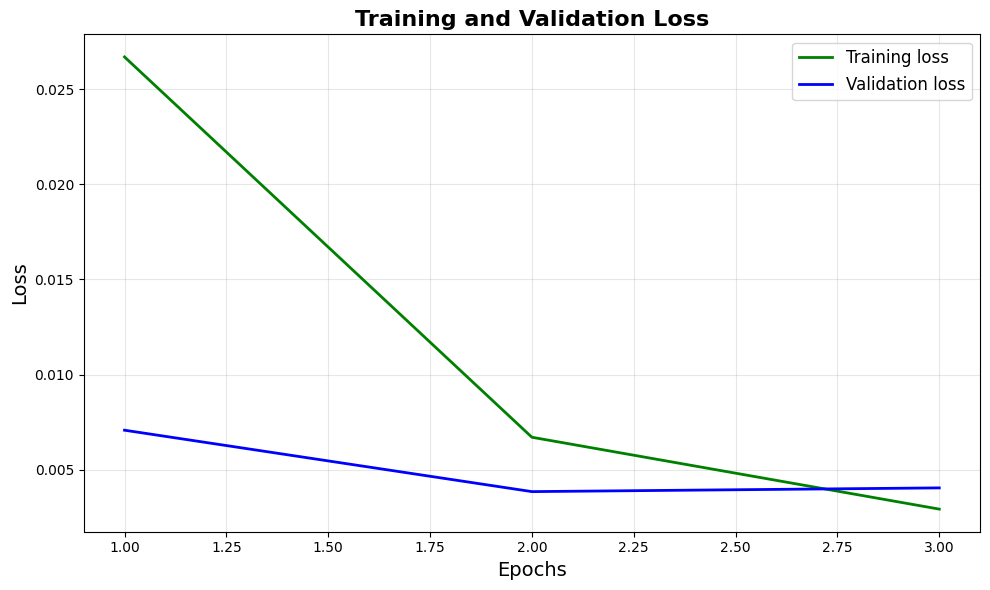

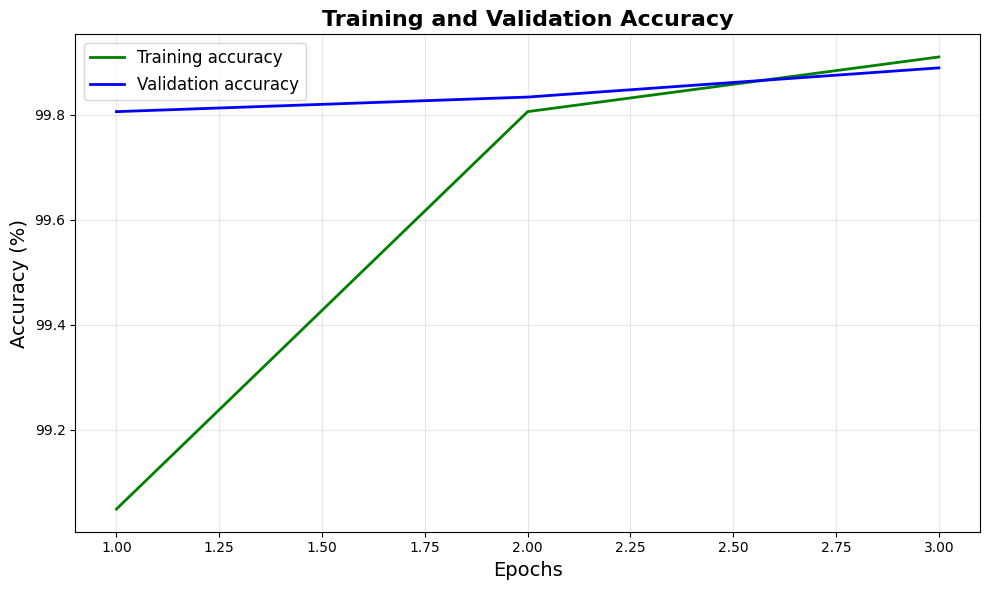


📊 Generating confusion matrix...

CONFUSION MATRIX
True Negative (Fake correctly identified) = 1799
False Positive (Real predicted as Fake) = 1
False Negative (Fake predicted as Real) = 3
True Positive (Real correctly identified) = 1797



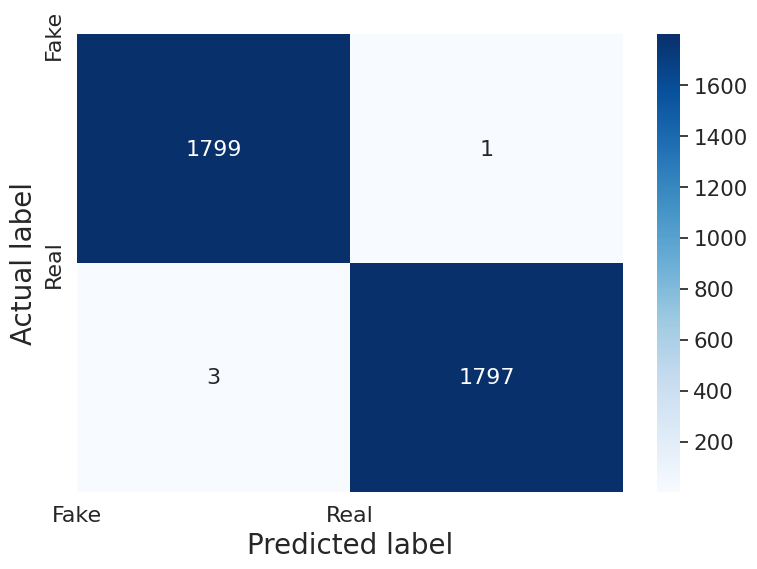

Calculated Accuracy: 99.89%

📥 SAVED FILES (Ready to Download)
  ✅ best_model.pt - Use this for your Flask app!
  ✅ deepfake_final_model.pth - Full checkpoint
  ✅ training_checkpoint.pth - Resume training
  ✅ confusion_matrix.png
  ✅ loss_plot.png
  ✅ accuracy_plot.png

🎉 ALL DONE!

📥 NEXT STEPS:
   1. Download 'best_model.pt' from /kaggle/working/
   2. Replace old model in D:\2\deepfake-detector\backend\
   3. Restart Flask app
   4. Test with new images!


In [22]:
print("\n" + "="*60)
print("✅ TRAINING COMPLETED!")
print("="*60)
print(f"🏆 Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"📊 Final Train Acc: {train_accuracy[-1]:.2f}%")
print(f"📊 Final Val Acc: {val_accuracy[-1]:.2f}%")
print("="*60)

print("\n📈 Generating plots...")
plot_metrics(train_loss_avg, val_loss_avg, train_accuracy, val_accuracy, len(train_loss_avg))

print("\n📊 Generating confusion matrix...")
print_confusion_matrix(true, pred)

final_model_path = '/kaggle/working/deepfake_final_model.pth'
torch.save({
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': train_loss_avg,
    'train_acc': train_accuracy,
    'val_loss': val_loss_avg,
    'val_acc': val_accuracy,
    'best_val_acc': best_val_acc
}, final_model_path)

print("\n" + "="*60)
print("📥 SAVED FILES (Ready to Download)")
print("="*60)
print(f"  ✅ best_model.pt - Use this for your Flask app!")
print(f"  ✅ deepfake_final_model.pth - Full checkpoint")
print(f"  ✅ training_checkpoint.pth - Resume training")
print(f"  ✅ confusion_matrix.png")
print(f"  ✅ loss_plot.png")
print(f"  ✅ accuracy_plot.png")
print("="*60)

print("\n🎉 ALL DONE!")
print("\n📥 NEXT STEPS:")
print("   1. Download 'best_model.pt' from /kaggle/working/")
print("   2. Replace old model in D:\\2\\deepfake-detector\\backend\\")
print("   3. Restart Flask app")
print("   4. Test with new images!")
print("="*60)